## Conditional Convolutional Variational Autoencoder

Some references:
- https://wiseodd.github.io/techblog/2016/12/17/conditional-vae/
- https://github.com/lyeoni/keras-mnist-CVAE/blob/master/keras-mnist-CVAE.ipynb

In [1]:
import tensorflow as tf
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt
import requests
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.manifold import TSNE
from functools import reduce
from tensorflow import keras as keras

In [3]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape, Lambda
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
oh_encoder = OneHotEncoder(categories='auto', sparse=False)
y_train_oh = oh_encoder.fit_transform(y_train.reshape(-1, 1))
y_test_oh = oh_encoder.transform(y_test.reshape(-1, 1))
x_train_1d = np.reshape(x_train, (x_train.shape[0], 28*28))
x_test_1d = np.reshape(x_test, (x_test.shape[0], 28*28))

In [5]:
n_batch = 50
n_x = x_train_1d.shape[1]
n_y = y_train_oh.shape[1]
n_z = 2
n_epoch = 20
n_hidden = 512

In [7]:
def sample_z(args):
    mu, log_var = args
    batch = K.shape(mu)[0]
    eps = K.random_normal(shape=(batch, n_z))
    return mu + K.exp(log_var / 2) * eps


In [13]:
# Q(z|X,y) -- encoder
X = Input(shape=(n_x,))
cond = Input(shape=(n_y,))

inputs = Concatenate(axis=1)([X, cond])
x_encoded = Dense(n_hidden, activation='relu')(inputs)
x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)
mu = Dense(n_z, activation='linear')(x_encoded)
log_var = Dense(n_z, activation='linear')(x_encoded)


In [14]:
z = Lambda(sample_z, output_shape=(n_z,))([mu, log_var])
z_cond = Concatenate(axis=-1)([z, cond])

In [15]:
# decoder
z_in = Input(shape=(n_z,))
cond_in = Input(shape=(n_y,))
dec_input = Concatenate(axis=1)([z_in, cond_in])
# dec_input = Input(shape=(n_z + cond.shape[1]))
# z_decoded = Dense(n_hidden//2, activation='relu')(z_cond)
z_decoded = Dense(n_hidden//2, activation='relu')(dec_input)
z_decoded = Dense(n_hidden, activation='relu')(z_decoded)
y = Dense(n_x, activation='sigmoid')(z_decoded)

In [16]:
encoder = Model([X, cond], [mu, log_var, z, cond])
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 794)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          407040      concatenate[0][0]            

In [17]:
decoder =  Model([z_in, cond_in], y)
decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 12)           0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 256)          3328        concatenate_2[0][0]        

In [18]:
output = decoder(encoder([X, cond])[2:])

In [19]:
# loss
reconstruction_loss = keras.losses.binary_crossentropy(X, output) * n_x
kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
cvae_loss = reconstruction_loss + kl_loss

cvae = Model([X, cond], output)
cvae.add_loss(cvae_loss)
cvae.compile(optimizer='adam')
cvae.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 2), (None, 2 539396      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 784)          537104      model[1][2]                

In [20]:
# train
cvae.fit([x_train_1d, y_train_oh],
       shuffle=True,
       epochs=50,
       batch_size=50,
       validation_data=([x_test_1d, y_test_oh], None), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 96us/sample - loss: 152.1239 - val_loss: 139.3029
Epoch 2/50
60000/60000 [==============================] - 5s 80us/sample - loss: 136.5197 - val_loss: 135.3800
Epoch 3/50
60000/60000 [==============================] - 5s 80us/sample - loss: 134.0698 - val_loss: 133.4098
Epoch 4/50
60000/60000 [==============================] - 5s 80us/sample - loss: 132.7227 - val_loss: 132.8770
Epoch 5/50
60000/60000 [==============================] - 5s 80us/sample - loss: 131.8294 - val_loss: 131.9998
Epoch 6/50
60000/60000 [==============================] - 5s 80us/sample - loss: 131.1470 - val_loss: 131.4941
Epoch 7/50
60000/60000 [==============================] - 5s 80us/sample - loss: 130.6401 - val_loss: 131.2882
Epoch 8/50
60000/60000 [==============================] - 5s 80us/sample - loss: 130.2178 - val_loss: 130.8126
Epoch 9/50
60000/60000 [==============================] - 5s 8

In [21]:
x_test_1d.shape

(10000, 784)

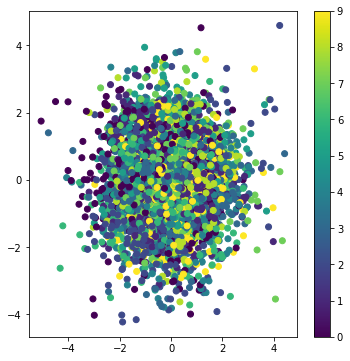

In [22]:
# Plot of the digit classes in the latent space
te_latent = encoder.predict(
    [x_test_1d, y_test_oh], 
    batch_size=50)

pred_mu, pred_var, pred_z, pred_cond = te_latent[0], te_latent[1], te_latent[2], te_latent[3]

plt.figure(figsize=(6, 6))
plt.scatter(pred_z[:, 0], pred_z[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [23]:
oh_encoder.transform([[1]])

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [24]:
def to_categorical(num):
    return oh_encoder.transform([[num]])[0]

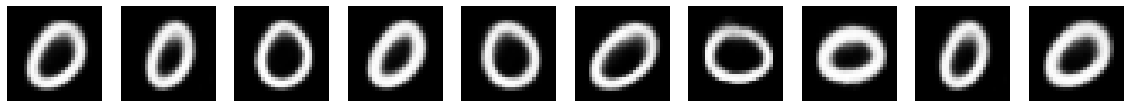

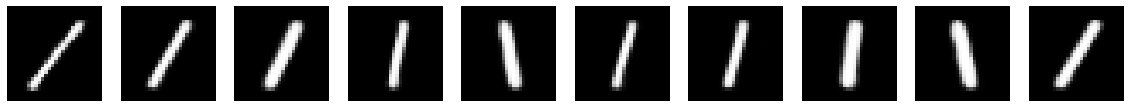

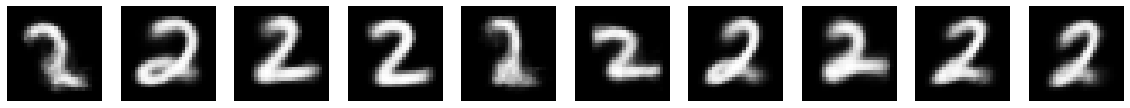

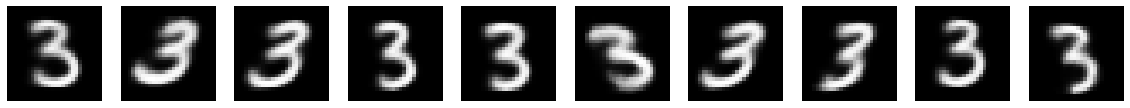

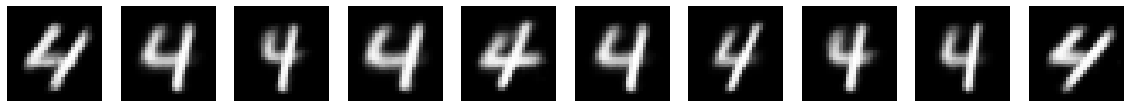

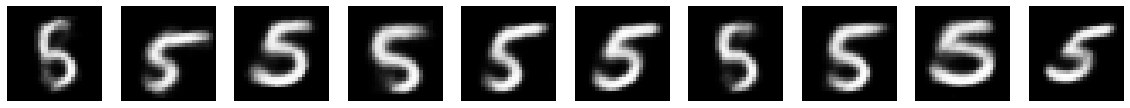

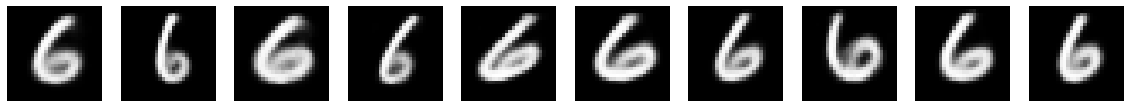

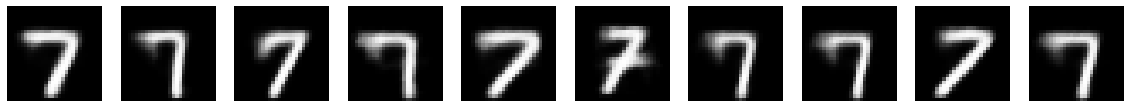

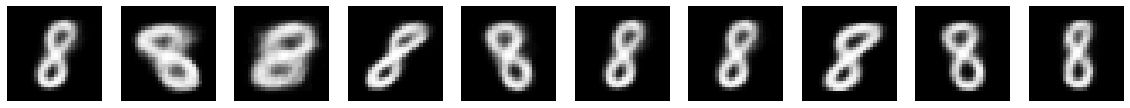

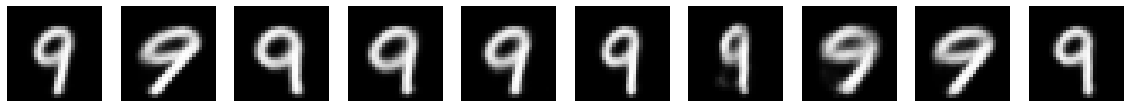

In [25]:
digit_size = 28
for cond_num in range(10):
    condition_num = np.array([to_categorical(cond_num)])
    plt.figure(figsize=(20, 2))

    for i in range(10):
        z_sample = np.random.randn(1,2)
        x_decoded = decoder.predict([z_sample, condition_num])
        digit = x_decoded[0].reshape(digit_size, digit_size)

        plt.subplot(1, 10, i+1)
        plt.axis('off')
        plt.imshow(digit, cmap='Greys_r',)

plt.show()
